In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial
from jax_tqdm import scan_tqdm

from algorithms.utils import save_state, restore_state

import numpy as np

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-21 20:36:21.894796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740166581.908412  268163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740166581.912483  268163 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv
from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = MicroGridEnv(params, battery_type)
    elif env_type == 'soc_action':
        env = MicroGridEnvSocAction(params, battery_type)
    else:
        raise ValueError('Unknown env_type')
    return env, env.params

In [5]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [6]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params

{'battery': {'sign_convention': 'passive',
  'params': {'nominal_voltage': 350.4,
   'nominal_capacity': 60.0,
   'nominal_dod': 0.8,
   'nominal_lifetime': 3000,
   'v_max': 398.4,
   'v_min': 288.0,
   'temp_ambient': 298.15,
   'nominal_cost': 3000.0},
  'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
   'current': {'low': -180.0, 'high': 60.0},
   'power': {'low': -71712.0, 'high': 23904.0},
   'temperature': {'low': 273.15, 'high': 323.15},
   'temp_ambient': {'low': 273.15, 'high': 323.15},
   'soc': {'low': 0.2, 'high': 1.0},
   'soh': {'low': 0.6, 'high': 1.0}},
  'init': {'voltage': 310.8,
   'current': 0.0,
   'power': 0.0,
   'temperature': 293.15,
   'temp_ambient': 293.15,
   'soc': 0.2,
   'soh': 1.0}},
 'input_var': 'current',
 'models_config': [{'type': 'electrical',
   'class_name': 'TheveninModel',
   'use_fading': False,
   'components': {'r0': {'selected_type': 'lookup',
     'scalar': 10.0,
     'lookup': {'table': 'r0_pack.csv',
      'inputs': [{'var': 'temp

In [7]:
a = jnp.array([[[[[[[2]]]]]]])
a = jnp.clip(a, 0, 1)
a.flatten()[0]
b = jnp.array(3)
b.flatten()

Array([3], dtype=int32, weak_type=True)

In [8]:
from algorithms.ppo import make_train, train
from flax.core.frozen_dict import freeze, unfreeze

In [9]:
num_envs = 4

config = {
    "LR": 1e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 8192, #2048 #10000,
    # "TOTAL_TIMESTEPS": 100000 * num_envs,
    "TOTAL_TIMESTEPS": 2*876000 * num_envs,
    "UPDATE_EPOCHS": 10,
    "NUM_MINIBATCHES": 32,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "NET_ARCH": (32, 16, 8), #(16, 16, 16),
    "ACTIVATION": 'tanh',
    "LOGISTIC_FUNCTION_TO_ACTOR": False,
    "ENV_NAME": None,
    "ANNEAL_LR": True,
    'DEBUG': False,
    "NORMALIZE_ADVANTAGES": True,
    "ENV_TYPE": 'normal',
}

env_type = config['ENV_TYPE']

rng = jax.random.PRNGKey(42)

env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env, env_params, train_state = make_train(config, env, env_params)
# out = train_jit(rng)

config = freeze(config)

In [10]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

In [11]:
network

ActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x797198321c60>,
    dot_general=<function dot_general at 0x7972300eae80>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x797198322020>,
    out_features=32,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <PjitFunction of <function tanh at 0x79722fda1a80>>, Linear(
    bias=Param(
      value=Array(shape=(16,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x79719836fe20>,
    dot_general=<function dot_general at 0x7972300eae80>,
    dtype=None,
    in_features=32,
    kernel=Param(
      value=Array(shape=(32, 16), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x79719836ff60>,
    out_features=16,
    param_dtype=<class '

Running for 213 iterations: 100%|██████████| 213/213 [10:36<00:00,  2.99s/it]


time: 651.95 s


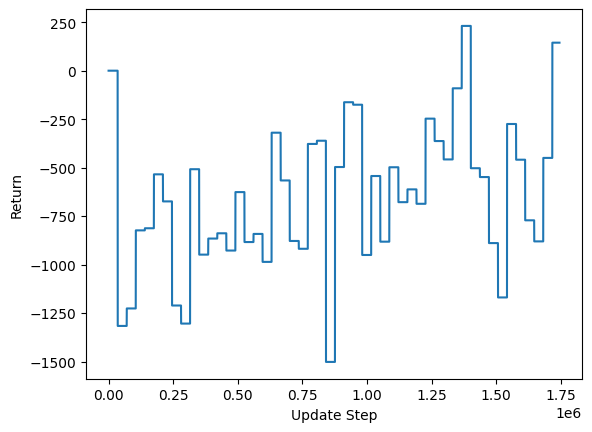

In [12]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = jax.block_until_ready(train(env, env_params, config, train_state, rng))

train_state = out['runner_state'][0]

print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [13]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)
network

ActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x797198321c60>,
    dot_general=<function dot_general at 0x7972300eae80>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x797198322020>,
    out_features=32,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <PjitFunction of <function tanh at 0x79722fda1a80>>, Linear(
    bias=Param(
      value=Array(shape=(16,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x79719836fe20>,
    dot_general=<function dot_general at 0x7972300eae80>,
    dtype=None,
    in_features=32,
    kernel=Param(
      value=Array(shape=(32, 16), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x79719836ff60>,
    out_features=16,
    param_dtype=<class '

## State saving

In [14]:
save_state(network, config, params, env_type=env_type, additional_info='double_training_steps')

In [15]:
out

{'metrics': {'action': Array([[[[ 1.1714847 ],
           [-0.38352498],
           [-0.8459018 ],
           [-0.58283925]],
  
          [[-1.2309304 ],
           [ 0.43994743],
           [-0.23875621],
           [ 0.25602952]],
  
          [[-0.1882001 ],
           [-0.05796093],
           [-1.2824068 ],
           [-0.2427557 ]],
  
          ...,
  
          [[-0.1232681 ],
           [ 0.9076646 ],
           [ 0.5929043 ],
           [-0.07001785]],
  
          [[ 0.72081715],
           [ 0.5903603 ],
           [-0.8165381 ],
           [ 1.8476772 ]],
  
          [[ 0.52579707],
           [ 1.5438398 ],
           [ 0.42595404],
           [ 0.681934  ]]],
  
  
         [[[ 1.0847665 ],
           [ 1.643116  ],
           [-0.578671  ],
           [-2.4917154 ]],
  
          [[-1.2414262 ],
           [-1.7479322 ],
           [-1.7602134 ],
           [ 1.0846221 ]],
  
          [[ 1.0202372 ],
           [-0.00732131],
           [ 0.94780296],
           [ 0.

In [16]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(1744896,)

In [17]:
acts = out['metrics']['action'].flatten()
acts.min(), acts.max(), acts.mean()

(Array(-4.5046854, dtype=float32),
 Array(4.5117836, dtype=float32),
 Array(-0.02944486, dtype=float32))

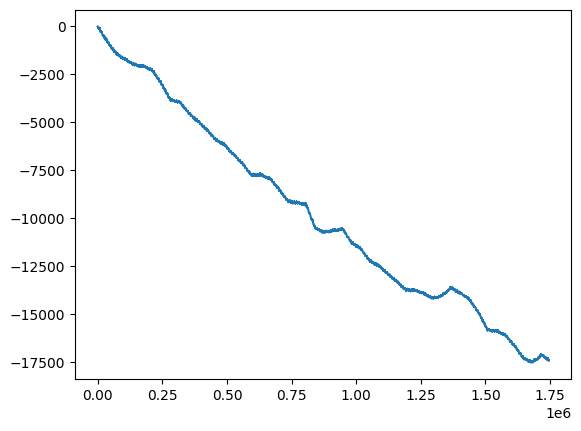

In [18]:
plt.plot(r_trad_cum)

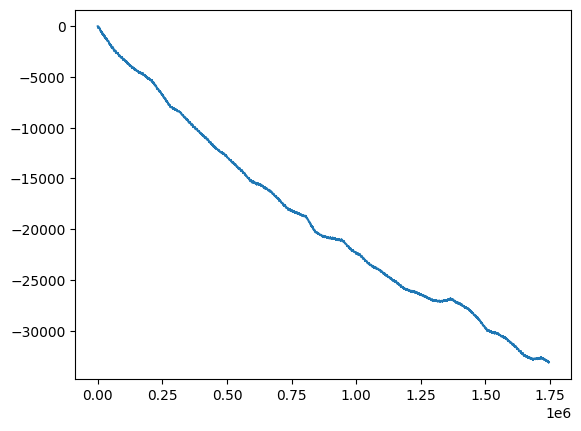

In [19]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [20]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [21]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [22]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

In [23]:
num_iter = 8760 * 8
info, actions = test(env, env_params, network, num_iter, jax.random.PRNGKey(51))


Running for 70,080 iterations: 100%|██████████| 70080/70080 [00:16<00:00, 4189.46it/s]


In [24]:
jax.tree.map(lambda val: val.shape, info)

{'i_to_apply': (70080,),
 'norm_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'pure_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'r_tot': (70080,),
 'soc': (70080,),
 'soh': (70080,),
 'weig_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)}}

In [25]:
actions.max(), actions.min(), actions.mean()

(Array(0.37122494, dtype=float32),
 Array(-0.38145635, dtype=float32),
 Array(-0.02139187, dtype=float32))

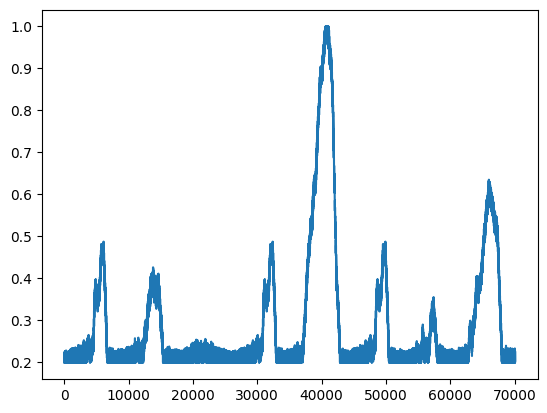

In [26]:
plt.plot(info['soc'])

In [27]:
reward_type = 'weig_reward'

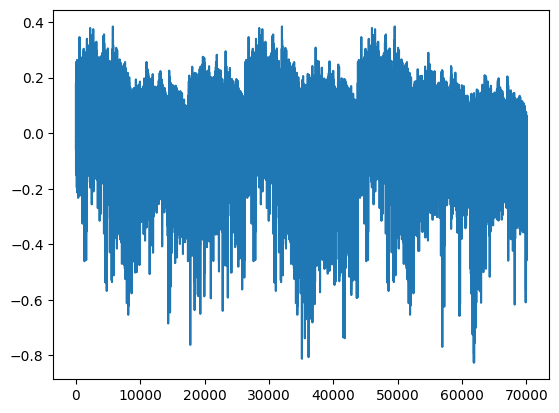

In [28]:
plt.plot(info[reward_type]['r_trad'])

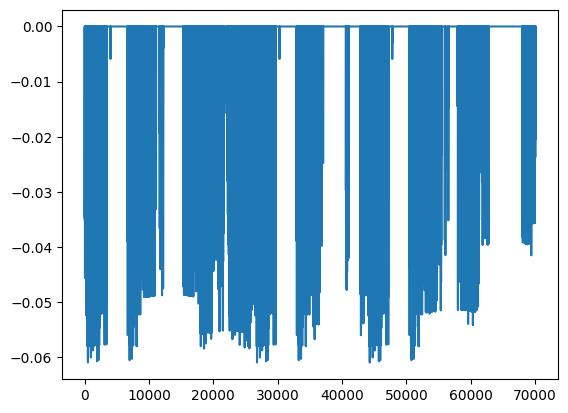

In [29]:
plt.plot(info[reward_type]['r_clipping'])

In [30]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-7.4818134, dtype=float32), Array(-0.00319381, dtype=float32))

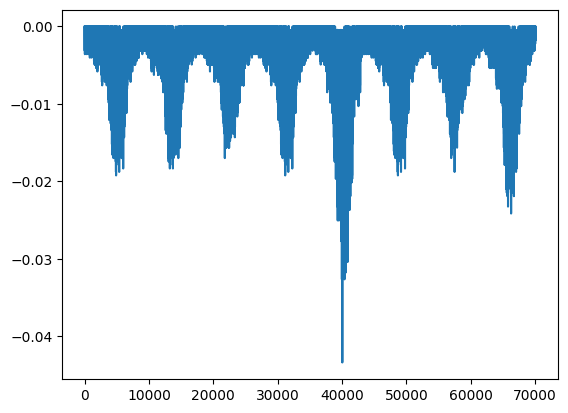

In [31]:
plt.plot(info[reward_type]['r_deg'])

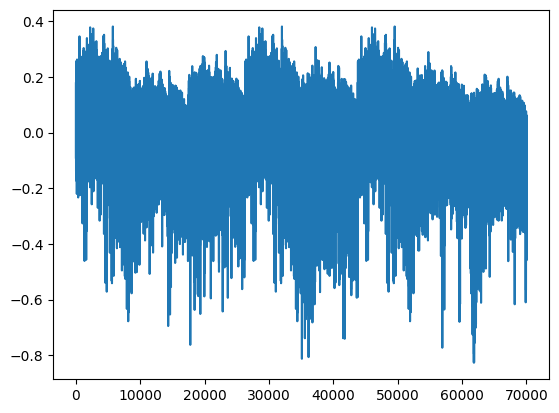

In [32]:
plt.plot(info['r_tot'])

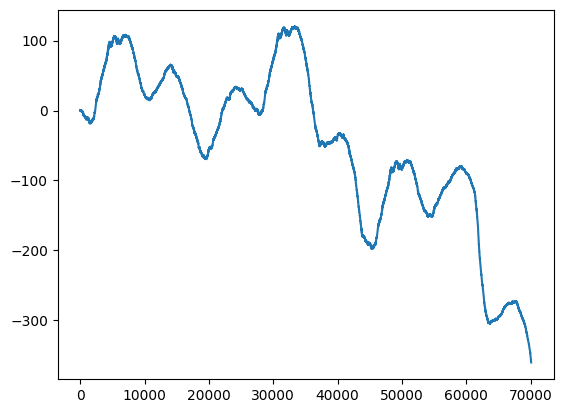

In [33]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

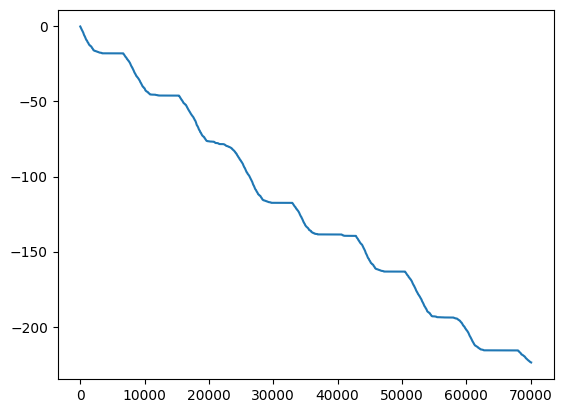

In [34]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

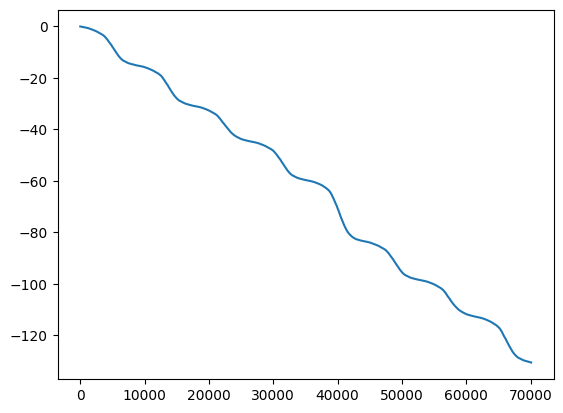

In [35]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

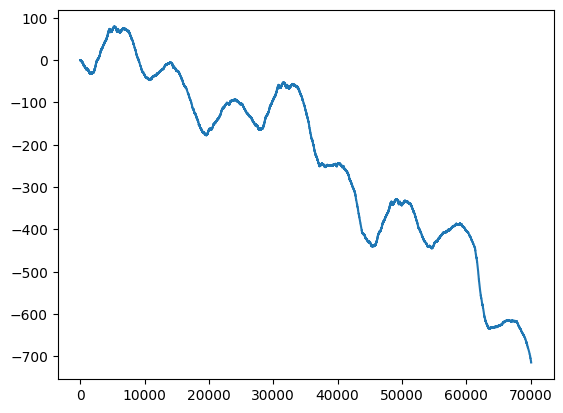

In [36]:
plt.plot(np.cumsum(info['r_tot']))

In [37]:
print(info['soc'])

[0.2        0.2        0.2        ... 0.20891401 0.20667101 0.20442802]


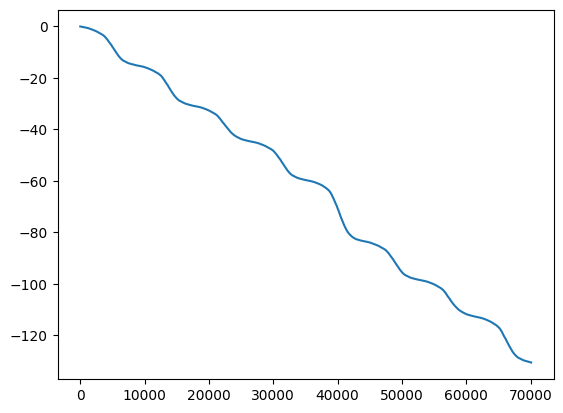

In [38]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [39]:
print(info['soc'])

[0.2        0.2        0.2        ... 0.20891401 0.20667101 0.20442802]
